# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 1. Load Dataset

In [2]:
df = pd.read_csv('./data/total_0509.csv')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
for i in list(df.columns):
    if i[0:2] == 'KR':
        print(i)

In [4]:
df.tail()

,Date,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,NZ_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,NZ_roam,TARGET,NEWS,covid_tr,coro_tr
100,2020-05-01,930930,83959,109157,1159804,1485,24.0,230.0,247.0,126.0,0.0,1073,1104.0,48.0,18.0
101,2020-05-02,942895,83959,114163,1190465,1487,77.0,90.0,254.0,174.0,0.0,1081,732.0,43.0,18.0
102,2020-05-03,950614,83964,119579,1218544,1487,48.0,130.0,248.0,104.0,0.0,1091,821.0,55.0,18.0
103,2020-05-04,957516,83966,125898,1242332,1486,51.0,94.0,238.0,95.0,0.0,1099,1331.0,30.0,17.0
104,2020-05-05,966279,83968,131413,1267566,1488,18.0,142.0,278.0,129.0,0.0,1102,793.0,30.0,17.0


In [7]:
tmp_cols = ['EURO_conf','CHINA_conf','ASIA_conf','N_AMERICA_conf','NZ_conf','TARGET']

In [8]:
for i in tmp_cols:
    df['{}'.format(i)] = df['{}'.format(i)].diff()

In [9]:
df.fillna(0, inplace=True)

In [10]:
df.Date = pd.to_datetime(df.Date)

In [11]:
df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [ ]:
#df.rename(columns={'target':'TARGET'},inplace=True)

## lag 변수 생성

In [12]:
lag_amount = 3

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['TARGET'].shift(i+1)
    
df.dropna(inplace=True)

In [13]:
df.head()

,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,NZ_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,NZ_roam,TARGET,NEWS,covid_tr,coro_tr,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,
2020-01-25,-1.0,209.0,-4.0,-1.0,0.0,1472.0,1825.0,7518.0,939.0,127.0,0.0,506.0,0.0,7.0,5,1.0,0.0,0.0
2020-01-26,-1.0,183.0,3.0,4.0,0.0,1932.0,3252.0,11149.0,1056.0,107.0,1.0,552.0,0.0,8.0,6,0.0,1.0,0.0
2020-01-27,1.0,133.0,-3.0,-4.0,0.0,2121.0,4226.0,14079.0,1354.0,146.0,1.0,576.0,0.0,13.0,0,1.0,0.0,1.0
2020-01-28,3.0,1830.0,12.0,1.0,0.0,1888.0,2854.0,11161.0,1212.0,55.0,0.0,711.0,0.0,17.0,1,1.0,1.0,0.0
2020-01-29,-3.0,-2054.0,-10.0,-1.0,0.0,1798.0,2416.0,9716.0,970.0,183.0,0.0,906.0,0.0,12.0,2,0.0,1.0,1.0


In [14]:
df.tail()

,EURO_conf,CHINA_conf,ASIA_conf,N_AMERICA_conf,NZ_conf,EURO_roam,CHINA_roam,ASIA_roam,N_AMERICA_roam,NZ_roam,TARGET,NEWS,covid_tr,coro_tr,dayofweek,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,,,,
2020-05-01,-1413.0,-9.0,971.0,4816.0,6.0,24.0,230.0,247.0,126.0,0.0,8.0,1104.0,48.0,18.0,4,4.0,5.0,12.0
2020-05-02,2722.0,-3.0,-639.0,-5262.0,2.0,77.0,90.0,254.0,174.0,0.0,8.0,732.0,43.0,18.0,5,8.0,4.0,5.0
2020-05-03,-4246.0,5.0,410.0,-2582.0,0.0,48.0,130.0,248.0,104.0,0.0,10.0,821.0,55.0,18.0,6,8.0,8.0,4.0
2020-05-04,-817.0,-3.0,903.0,-4291.0,-1.0,51.0,94.0,238.0,95.0,0.0,8.0,1331.0,30.0,17.0,0,10.0,8.0,8.0
2020-05-05,1861.0,0.0,-804.0,1446.0,2.0,18.0,142.0,278.0,129.0,0.0,3.0,793.0,30.0,17.0,1,8.0,10.0,8.0


# Data Exploration

In [15]:
# 결측치 확인
df.isnull().sum().sum()

0

In [16]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['TARGET'].shape))

전체 데이터 shape: (102, 18)
target feature shape: (102,)


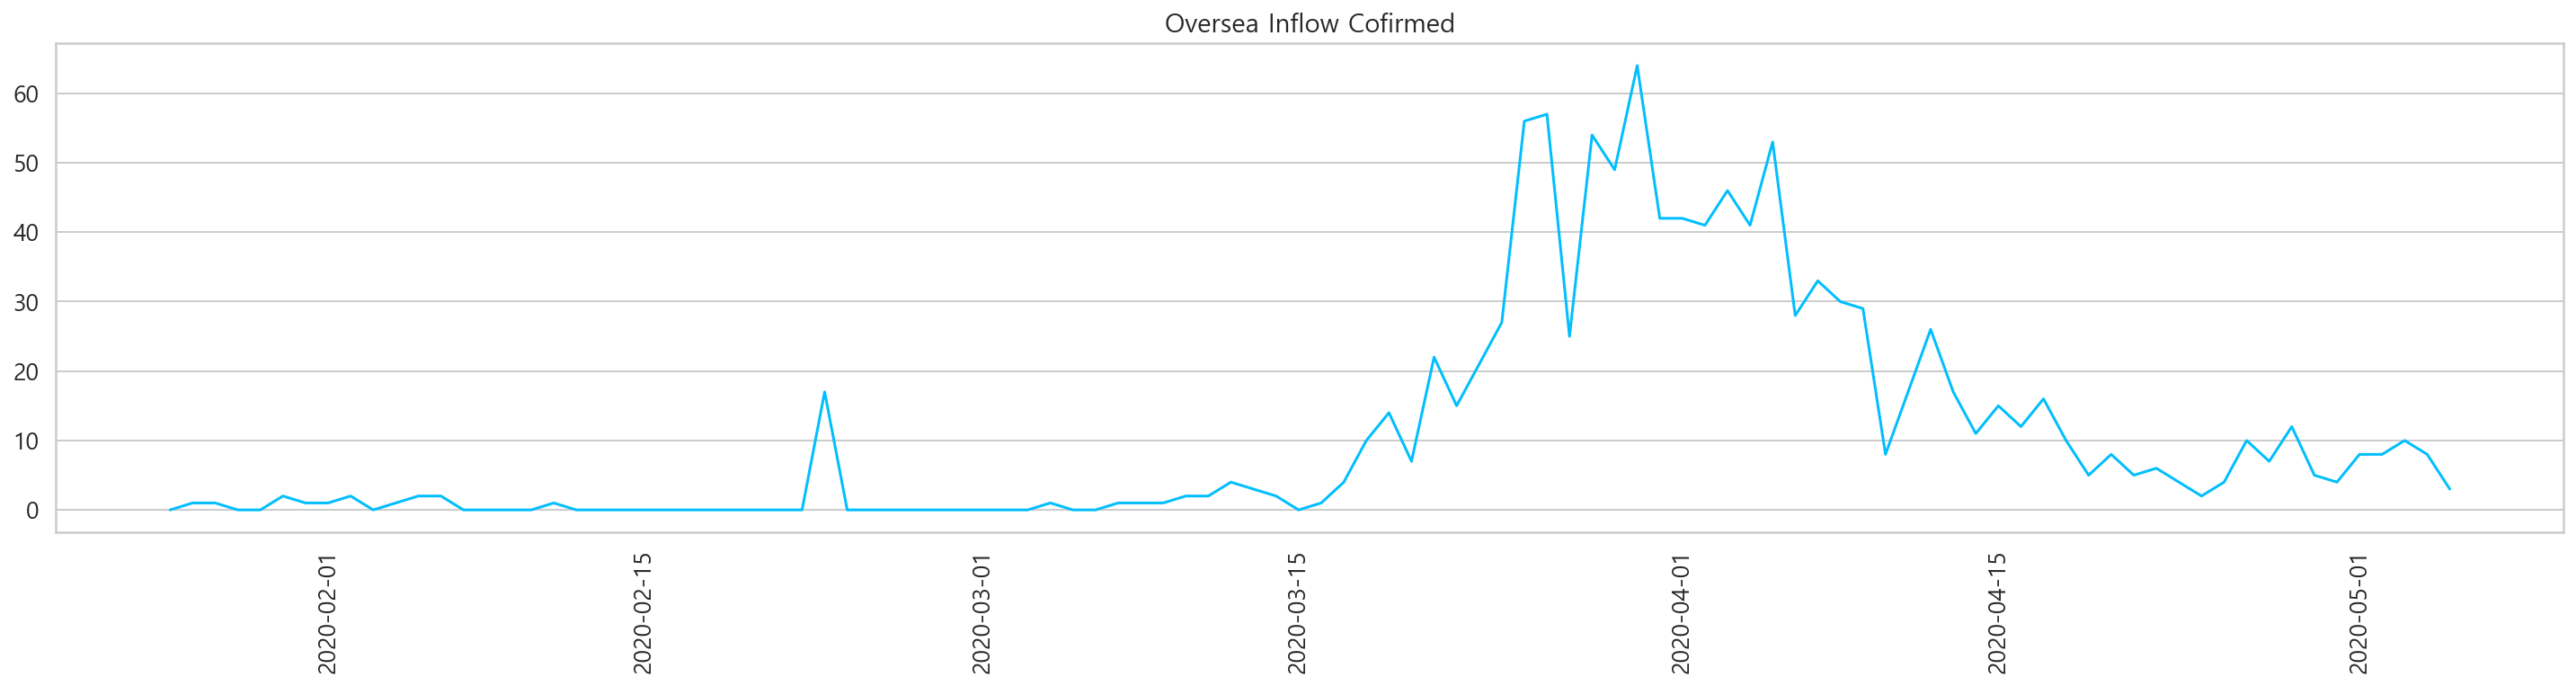

In [17]:
plt.figure(figsize=(25,5))
plt.plot(df['TARGET'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

## Feature Selection

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
X_cols = list(df.columns)
X_cols.remove('TARGET')

In [20]:
# X변수들과 y변수 구분
X = df[X_cols]
y = df['TARGET']

In [21]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
param_grid = { 
    'n_estimators': [30, 110, 140],
    'min_samples_leaf' : [4, 18, 3],
    'min_samples_split' : [8, 4, 6],
}

In [86]:
# grid search
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [87]:
CV_rfc

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [88]:
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
CV_rfc.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 30}

In [90]:
# parameter 설정후에 다시 진행
rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, min_samples_split=4, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
4,OCEANIA_conf,0.400
0,EURO_conf,0.212
12,lag1,0.175
14,lag3,0.116
2,ASIA_conf,0.018
1,CHINA_conf,0.016
5,EURO_roam,0.015
8,N_AMERICA_roam,0.011
13,lag2,0.009
3,N_AMERICA_conf,0.008


In [97]:
df.columns.__len__()

16

In [92]:
#df_importance.to_csv('feature_importance.csv')

Text(0, 0.5, '변수')

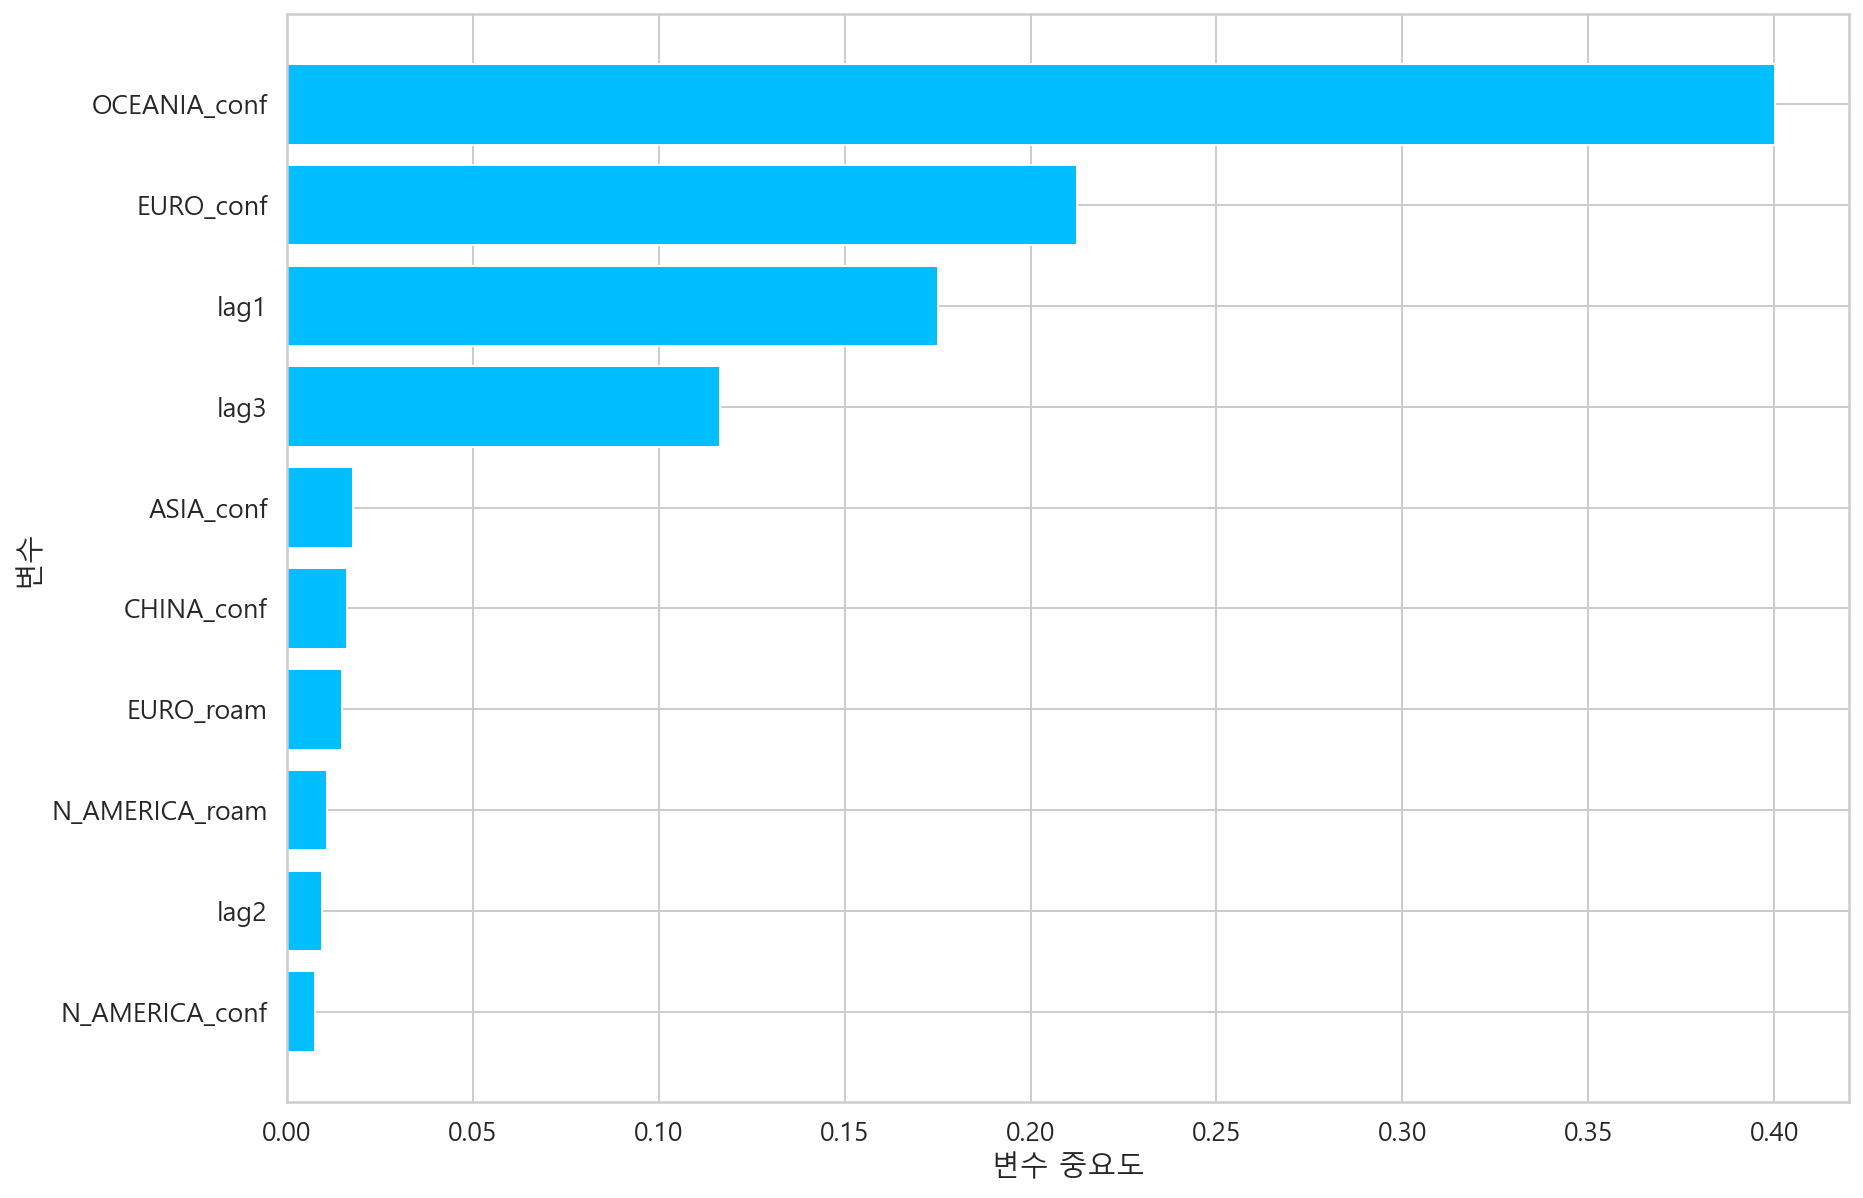

In [93]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(10)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# LSTM Model

In [26]:
X_cols = list(df.columns)
X_cols.remove('TARGET')
#new_x_cols = list(df_importance1['Feature'])

In [24]:
#X_cols = ['NZ_conf', 'DE_conf', 'lag1', 'covid_tr', 'CZ_conf', 'lag3']

In [27]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분

# # 앞의 40개는 지우기
# X = df[40:][X_cols]
# y = df[40:]['TARGET']

X = df[X_cols]
y = df['TARGET']

In [28]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [29]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (88, 17)
test set :  (14, 17)


In [30]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [31]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [32]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [33]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([88, 1, 17])
X_test : torch.Size([14, 1, 17])
y_train : torch.Size([88, 1])
y_test : torch.Size([14, 1])


# Building a Model

In [34]:
# 파라미터 저장할 리스트 생성
param_list = []

In [35]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [36]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [37]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=250

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.078 test loss: 0.0022
Epoch 10 train loss: 0.0726 test loss: 0.0021
Epoch 20 train loss: 0.0682 test loss: 0.0034
Epoch 30 train loss: 0.0642 test loss: 0.0059
Epoch 40 train loss: 0.0599 test loss: 0.0094
Epoch 50 train loss: 0.0545 test loss: 0.0145
Epoch 60 train loss: 0.0472 test loss: 0.0222
Epoch 70 train loss: 0.0383 test loss: 0.0352
Epoch 80 train loss: 0.0299 test loss: 0.0564
Epoch 90 train loss: 0.0261 test loss: 0.0782
Epoch 100 train loss: 0.0241 test loss: 0.0776
Epoch 110 train loss: 0.0219 test loss: 0.0633
Epoch 120 train loss: 0.0196 test loss: 0.0537
Epoch 130 train loss: 0.0171 test loss: 0.0472
Epoch 140 train loss: 0.0144 test loss: 0.0382
Epoch 150 train loss: 0.012 test loss: 0.0279
Epoch 160 train loss: 0.0101 test loss: 0.0194
Epoch 170 train loss: 0.009 test loss: 0.0129
Epoch 180 train loss: 0.0084 test loss: 0.009
Epoch 190 train loss: 0.0081 test loss: 0.0071
Epoch 200 train loss: 0.008 test loss: 0.0065
Epoch 210 train loss: 0.0079 

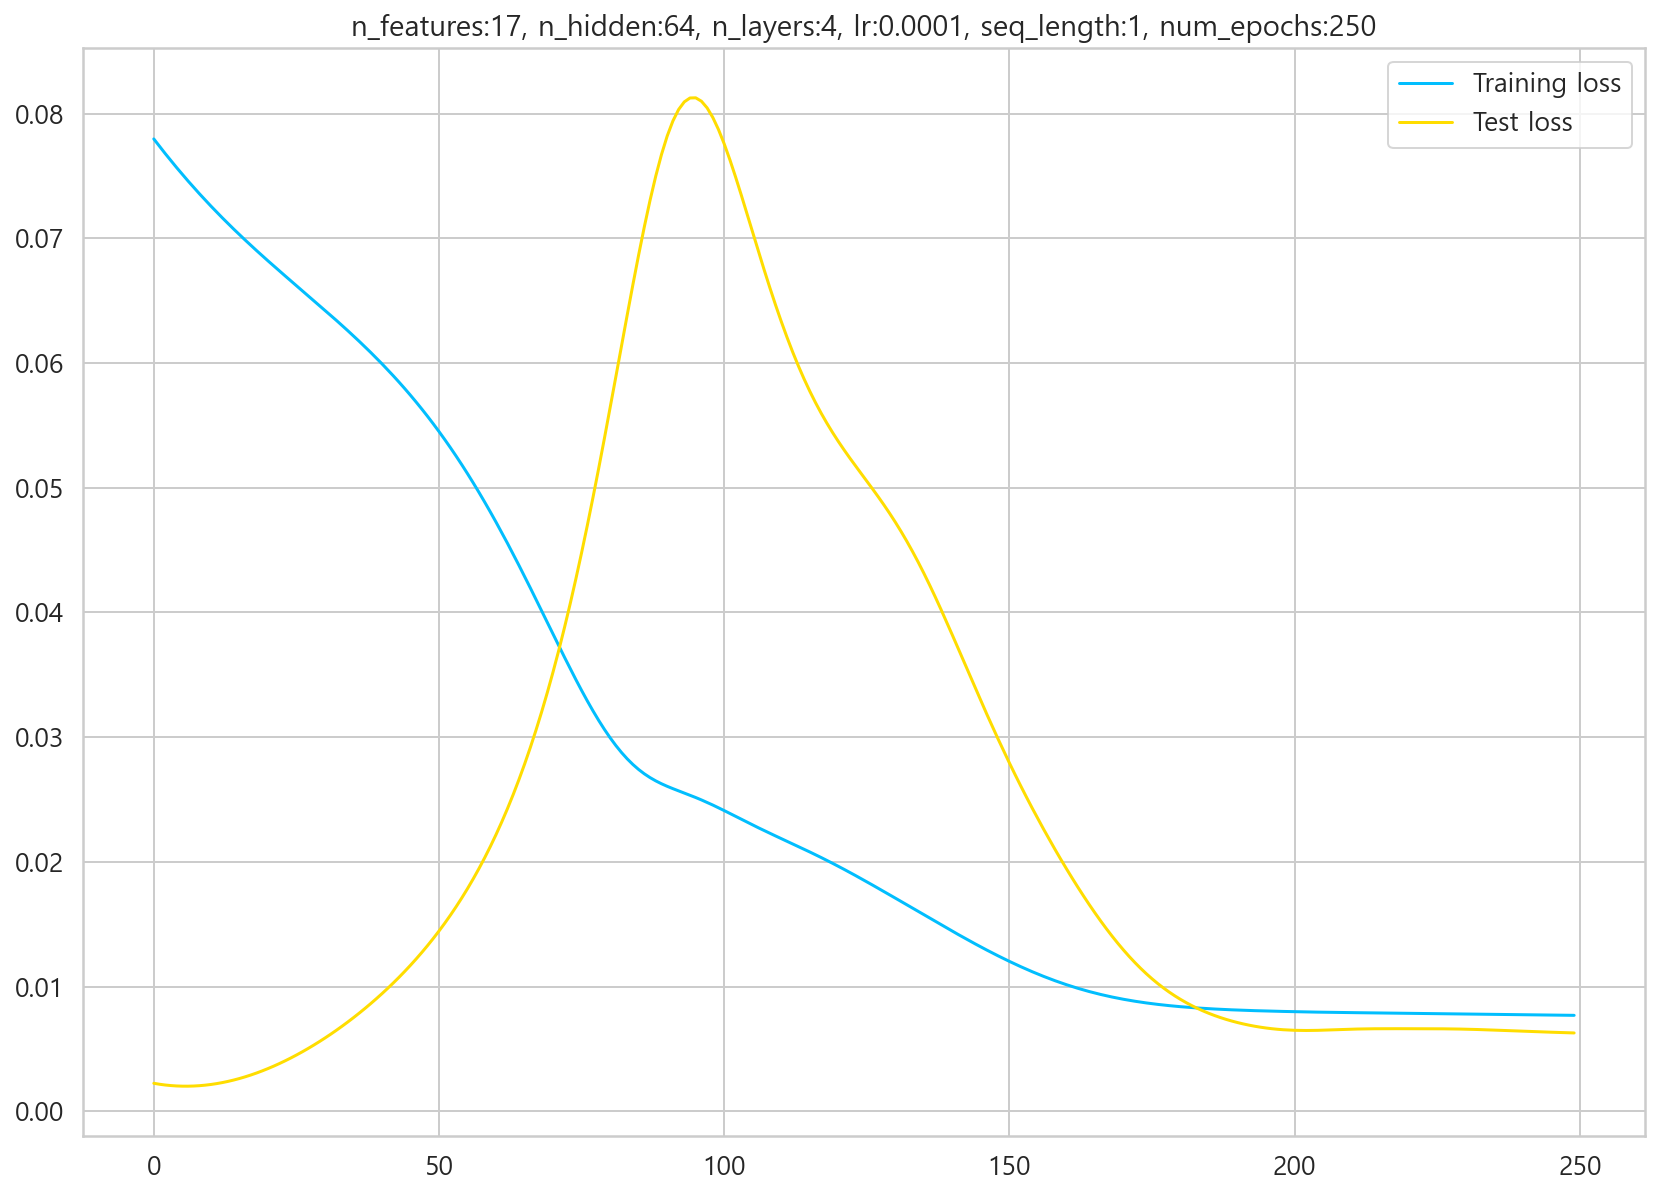

In [38]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [49]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [50]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [51]:
pred_values_ceiled  = list(pred_values.flatten())

In [52]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [53]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [54]:
score_table

,True,Pred
0,6.0,14.961082
1,4.0,15.042836
2,2.0,15.228292
3,4.0,15.524069
4,10.0,15.354928
5,7.0,14.655593
6,12.0,13.744921
7,5.0,12.895166
8,4.0,12.933817
9,8.0,14.068709


In [55]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [56]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 75.2701640731271, RMSE : 8.675837946453766, SCORE : -49.04982984777644


In [47]:
param_list.append([n_features, n_hidden, n_layers, lr, num_epochs, MSE, RMSE, score])
param_table=pd.DataFrame(param_list,columns=['n_features', 'n_hidden', 'n_layers', 'lr', 'num_epochs', 'MSE', 'RMSE', 'score'])
param_table

,n_features,n_hidden,n_layers,lr,num_epochs,MSE,RMSE,score
0,17,64,4,0.0001,250,72.083667,8.49021,-42.739936


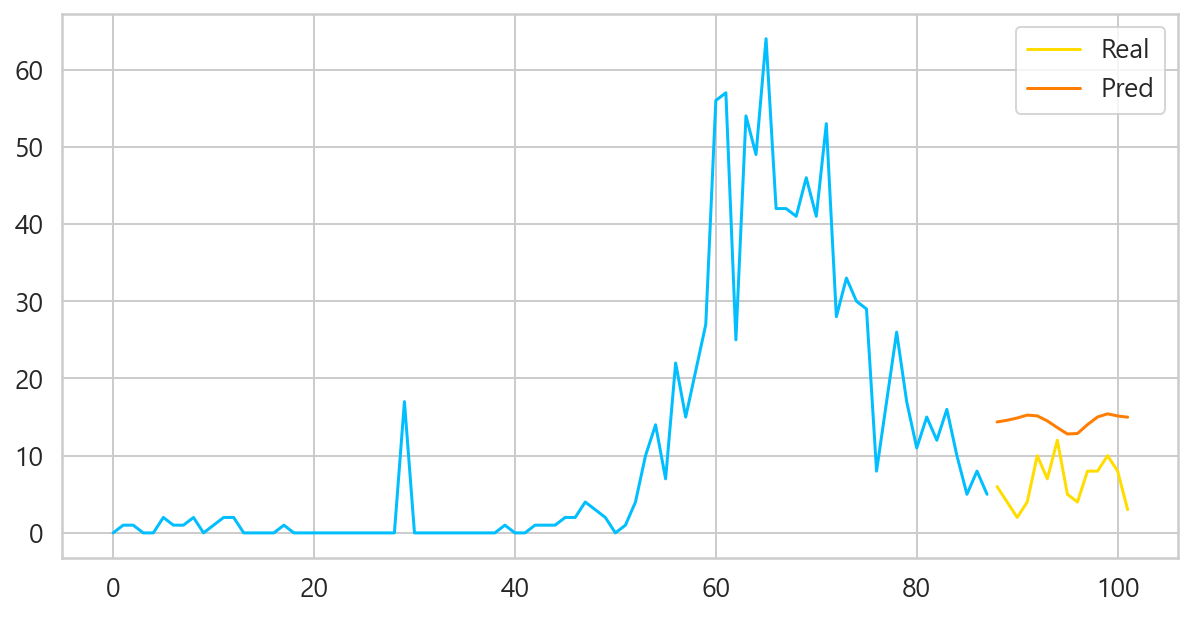

In [48]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [ ]:
# 모델 저장
PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
torch.save(model, PATH)
# 모델 불러오기
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [164]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['TARGET']

In [165]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [166]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [173]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  torch.Size([102, 1, 15])
y_all :  torch.Size([102, 1])


In [174]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

ValueError: only one element tensors can be converted to Python scalars

In [175]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

Epoch 0 train loss: 0.1371423304080963
Epoch 10 train loss: 0.12147509306669235
Epoch 20 train loss: 0.10805083066225052


KeyboardInterrupt: 

# Predicting future cases

In [170]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [171]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [172]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[-2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

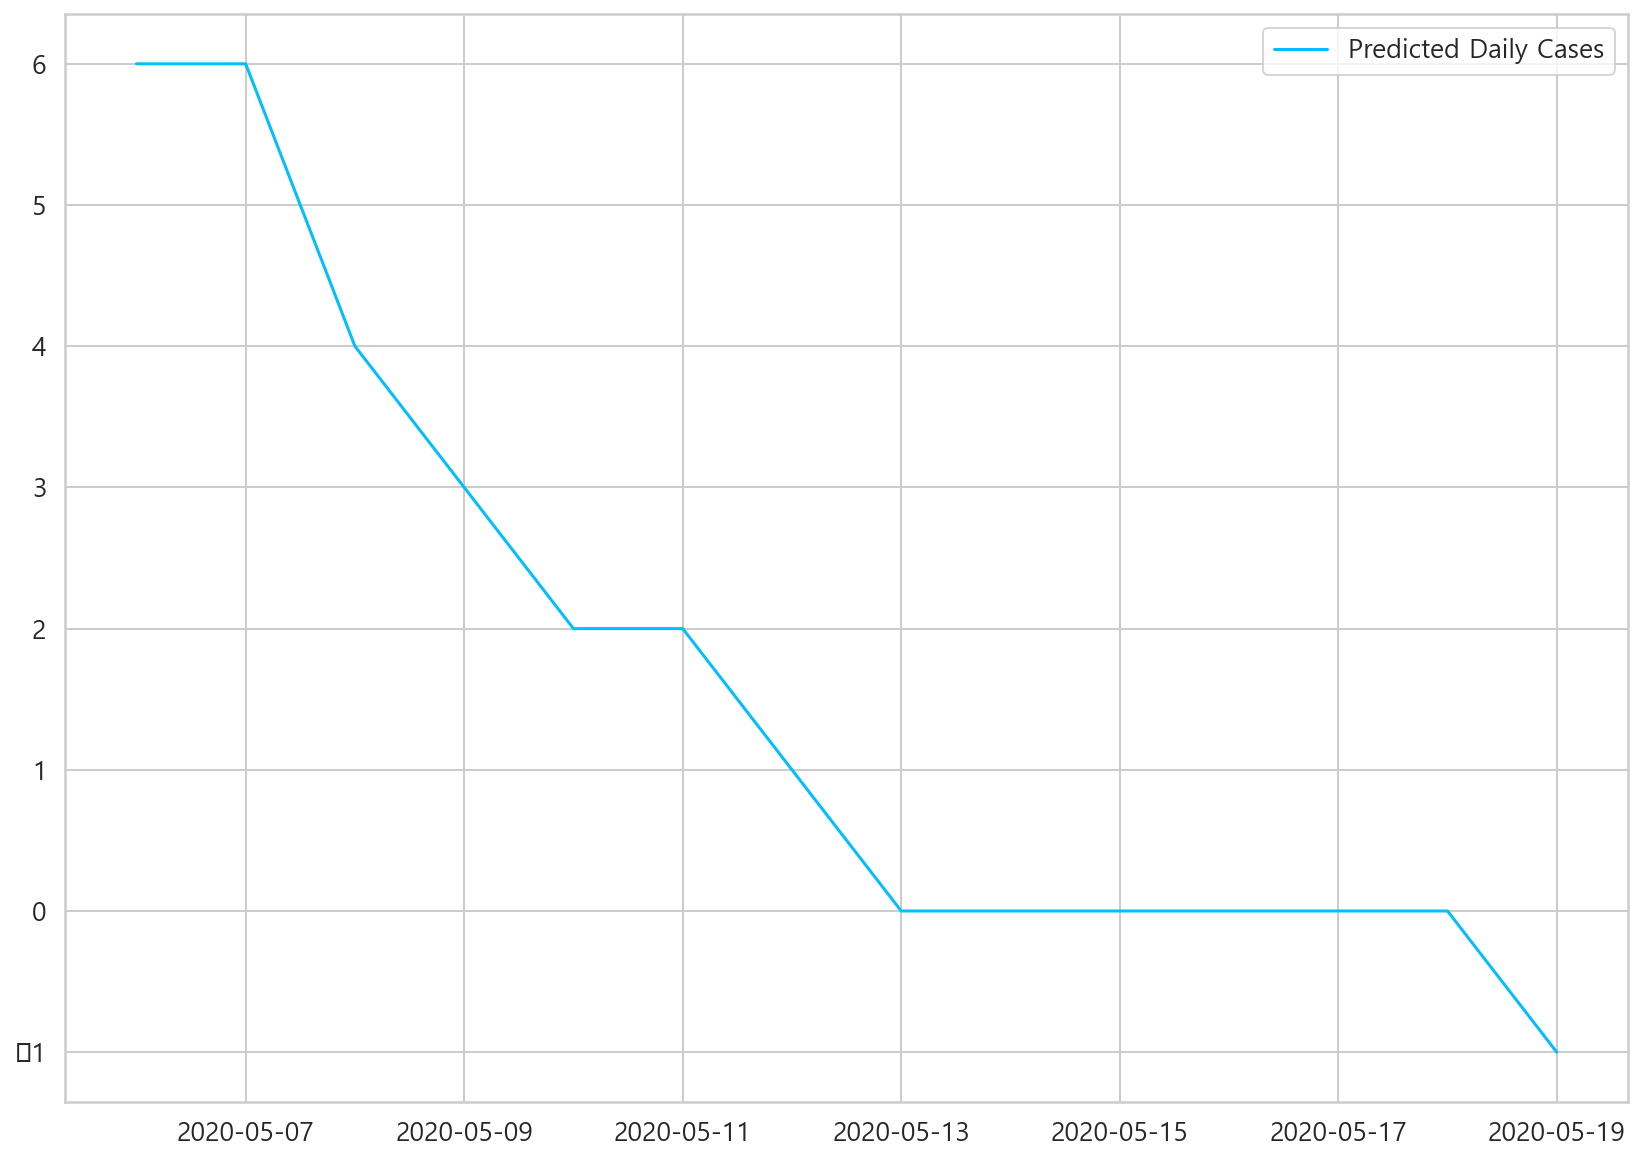

In [152]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [153]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [154]:
preds_

,0
2020-05-06,6
2020-05-07,6
2020-05-08,4
2020-05-09,3
2020-05-10,2
2020-05-11,2
2020-05-12,1
2020-05-13,0
2020-05-14,0
2020-05-15,0


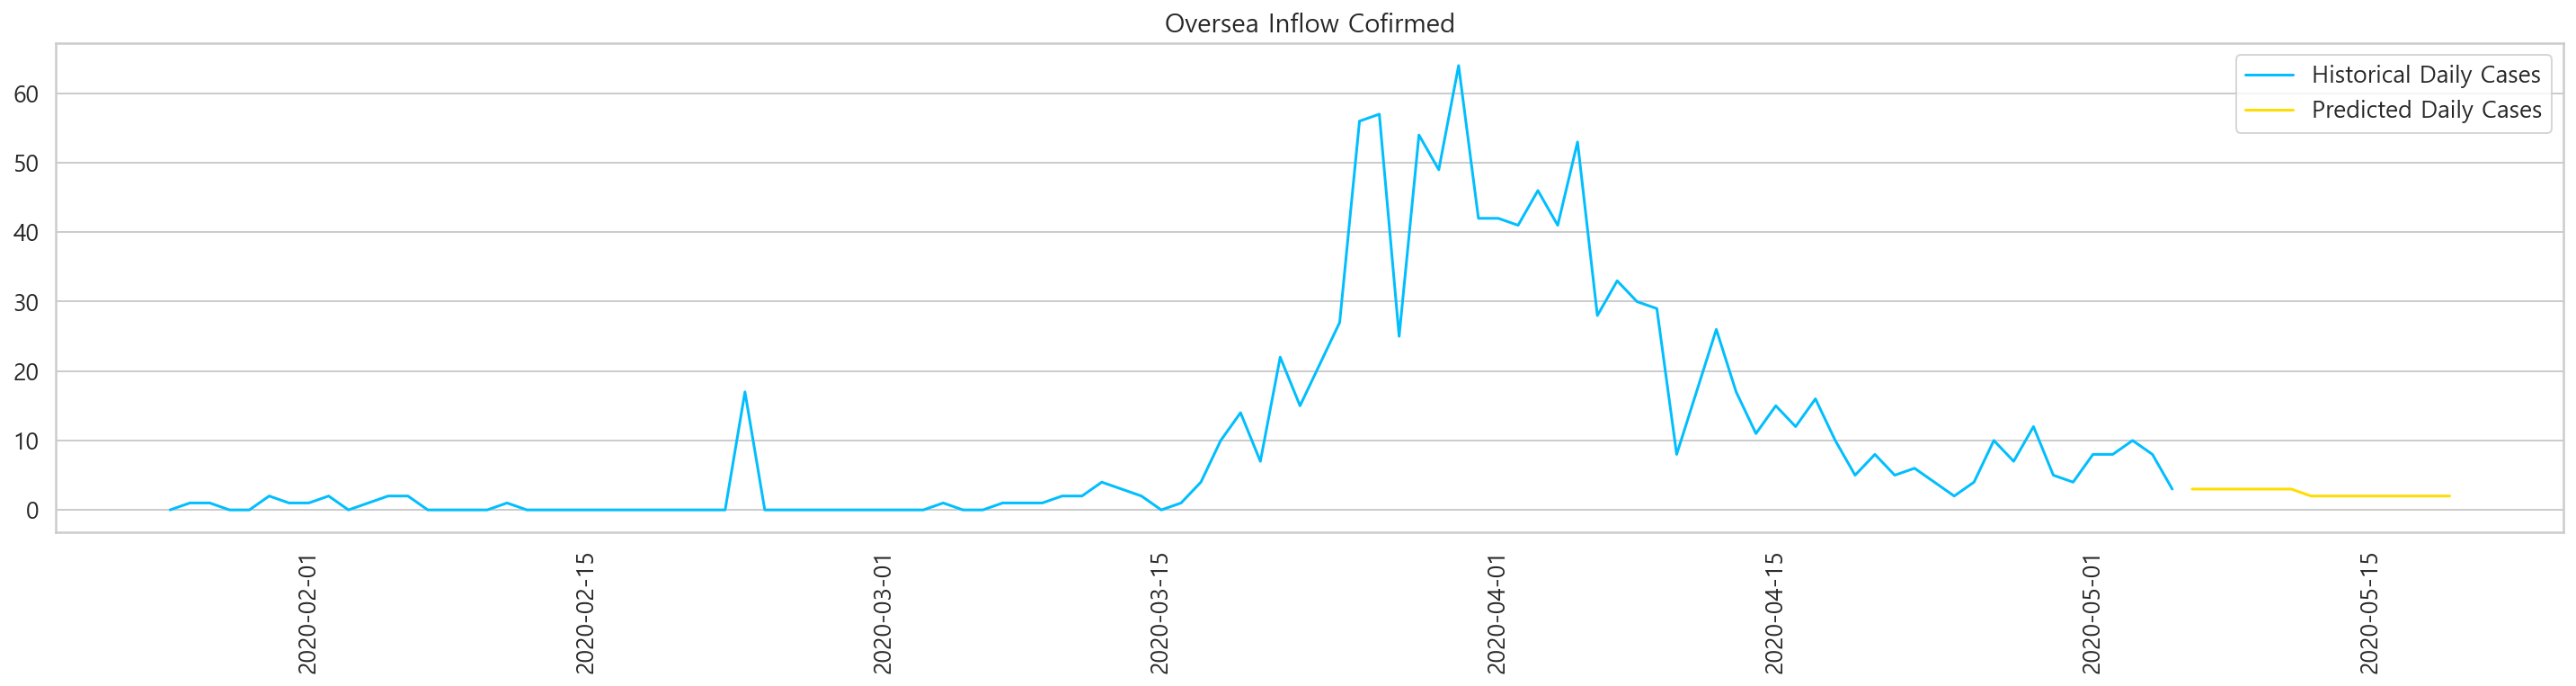

In [1667]:
plt.figure(figsize=(25,5))
plt.plot(df['TARGET'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();